# Учебный Проект → «Бета-Банк»

<div class="alert alert-info" role="alert">
    <span style="font-size:0.7rem">Student's note</span>
    <p class="mb-0">В коде использую <code>display()</code> намеренно, потомучто это однозначно даёт понять что планируется вывод / печать результатов. 👌</p>
</div>

## Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
Постройте модель с предельно большим значением f1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте f1-меру на тестовой выборке самостоятельно.
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с f1-мерой.




In [1]:
import pandas as pd
import sklearn
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import rcParams

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# from sklearn.tree import ExtraTreeClassifier
# from sklearn.dummy import DummyClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

from random import randint

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
# style MATPLOTLIBRC
custom_params = {
                'figure.figsize': (10, 6),
                'figure.facecolor': '#232425',
                'figure.dpi': 240,

                'legend.frameon': False,
                'legend.borderpad': 1.4,
                'legend.labelspacing': 0.7,
                'legend.handlelength': 0.7,
                'legend.handleheight': 0.7,

                'axes.facecolor': '#232425',
                'axes.labelcolor': '#EEEEEE',
                'axes.labelpad': 17,
                'axes.spines.left': False,
                'axes.spines.bottom': False,
                'axes.spines.right': False,
                'axes.spines.top': False,
                'axes.grid': False,

                'contour.linewidth': 0.0,

                'xtick.color': '#AAAAAA',
                'ytick.color': '#AAAAAA',
                'xtick.bottom': True,
                'xtick.top': False,
                'ytick.left': True,
                'ytick.right': False,
    
                "lines.color": '#EEEEEE',

                'text.color': '#EEEEEE',
    
                'font.family': 'sans-serif',
                # 'font.sans-serif': [
                #     'Helvetica',
                #     'Verdana',
                #     'Tahoma',
                #     'Trebuchet MS',
                #     'Arial',
                #     'Chevin'
                #     ]
                }

# rcParams.update(custom_params)

In [4]:
random_seed = 108108108

## Загрузите и подготовьте данные.

In [5]:
try:
    customers_data = pd.read_csv('./datasets/churn.csv')
except FileNotFoundError:
    customers_data = pd.read_csv(
        'https://code.s3.yandex.net/datasets/Churn.csv'
    )
    print('FYI data loaded via url')

In [6]:
display(
    customers_data.head(5)
)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [7]:
display(
    len(customers_data['CustomerId'].unique())
)

10000

Удалим столбцы, которые не несут информации..

In [8]:
customers_data.drop(
    columns=['RowNumber',  'Surname'],
    inplace=True
)

Сделаем названия столбцов по+красоте -> `snake_case`

In [9]:
customers_data.columns  = pd.Series(customers_data.columns).apply(
    lambda c: re.sub(r'(?<!^)(?=[A-Z])', '_',  c ).lower()
)

Оставим `customer_id` как индекс.

In [10]:
customers_data.set_index(
    keys='customer_id',
    inplace=True
)

Пробовал в колонке `tenure` заменить `NaN` на медиану. Резудьтат модели не устроил. Медиана всего столбца, кстати, очень близка к мединане в группировке по странам, полу.  
Поэтому удалим все сторки где `tenure` = `NaN`.

In [11]:
display(
    customers_data.loc[customers_data['tenure'].isna()].sample(7)
)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
customer_id,,,,,,,,,,,
15648876,501,France,Female,34,NaN,0.00,1,1,0,27380.99,0
15576526,850,Spain,Male,36,NaN,0.00,2,0,1,41291.05,0
15625623,567,France,Female,45,NaN,0.00,2,0,1,121053.19,0
15714240,712,Spain,Male,74,NaN,0.00,2,0,0,151425.82,0
15641994,667,Germany,Male,43,NaN,103018.45,1,1,0,32462.39,1
15776404,523,France,Male,22,NaN,123374.46,1,1,1,124906.59,0
15750803,693,France,Female,30,NaN,127992.25,1,1,1,50457.20,0


In [12]:
customers_data.dropna(axis=0, inplace=True)

In [13]:
display(
    customers_data.info()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 15634602 to 15682355
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   geography         9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   tenure            9091 non-null   float64
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   int64  
 7   has_cr_card       9091 non-null   int64  
 8   is_active_member  9091 non-null   int64  
 9   estimated_salary  9091 non-null   float64
 10  exited            9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 852.3+ KB


None

In [14]:
col_type = {
    'credit_score': 'uint16',
     'geography': 'category',
     'gender': 'category',
     'age': 'uint8',
     'tenure': 'uint8',
     'balance': 'float64',
     'num_of_products': 'uint8',
     'has_cr_card': 'category',
     'is_active_member': 'category',
     'estimated_salary': 'float64',
     'exited': 'category',
}

num_col = [
    'credit_score',
     'age',
     'tenure',
     'balance',
     'num_of_products',
     'estimated_salary',
]

In [15]:
customers_data = customers_data.astype(col_type)

In [16]:
display(
    customers_data.info()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 15634602 to 15682355
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   credit_score      9091 non-null   uint16  
 1   geography         9091 non-null   category
 2   gender            9091 non-null   category
 3   age               9091 non-null   uint8   
 4   tenure            9091 non-null   uint8   
 5   balance           9091 non-null   float64 
 6   num_of_products   9091 non-null   uint8   
 7   has_cr_card       9091 non-null   category
 8   is_active_member  9091 non-null   category
 9   estimated_salary  9091 non-null   float64 
 10  exited            9091 non-null   category
dtypes: category(5), float64(2), uint16(1), uint8(3)
memory usage: 302.5 KB


None

In [17]:
display(
    customers_data[num_col].describe()
)

,credit_score,age,tenure,balance,num_of_products,estimated_salary
count,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000
mean,650.736553,38.949181,4.997690,76522.740015,1.530195,100181.214924
std,96.410471,10.555581,2.894723,62329.528576,0.581003,57624.755647
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,51227.745000
50%,652.000000,37.000000,5.000000,97318.250000,1.000000,100240.200000
75%,717.000000,44.000000,7.000000,127561.890000,2.000000,149567.210000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


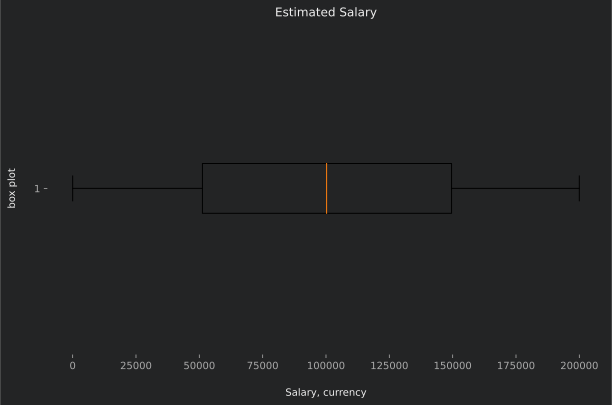

In [18]:
with mpl.rc_context(custom_params):
    plt.boxplot(
        customers_data['estimated_salary'],
        vert=False
    )
    plt.title('Estimated Salary')
    plt.xlabel('Salary, currency')
    plt.ylabel('box plot')
    
    
    plt.draw()

Поясните порядок действий.

In [19]:
target = customers_data['exited']
features = customers_data.drop('exited', axis=1)

In [20]:
cat_col = list(set(features) - set(num_col))

In [21]:
encoder = OrdinalEncoder()

In [22]:
features_ordinal = pd.DataFrame(
    encoder.fit_transform(features), 
    columns=features.columns
)

In [23]:
display(
features_ordinal.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   float64
 1   geography         9091 non-null   float64
 2   gender            9091 non-null   float64
 3   age               9091 non-null   float64
 4   tenure            9091 non-null   float64
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   float64
 7   has_cr_card       9091 non-null   float64
 8   is_active_member  9091 non-null   float64
 9   estimated_salary  9091 non-null   float64
dtypes: float64(10)
memory usage: 710.4 KB


None

## Исследуйте баланс классов, обучите модель без учёта дисбаланса.

### Обучим случайный лес RandomForestClassifier

In [24]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_ordinal,
    target,
    test_size=0.2,
    random_state=random_seed,
)

features_train, features_test, target_train, target_test = train_test_split(
    features_train,
    target_train,
    test_size=0.25,
    random_state=random_seed,
)

Без стратификации по `exited`

In [25]:
print(
    'train amount:\t{:.2%}'.format(len(target_train) / len(target)),
    'valid amount:\t{:.2%}'.format(len(target_valid) / len(target)),
    'test amount:\t{:.2%}'.format(len(target_test) / len(target)),
    '\n',
    'train\'s exited:\t{:.2%}'.format(sum(target_train) / len(target_train)),
    'valid\'s exited:\t{:.2%}'.format(sum(target_valid) / len(target_valid)),
    'test\'s exited:\t{:.2%}'.format(sum(target_test) / len(target_test)),
    sep='\n'
)

train amount:	59.99%
valid amount:	20.01%
test amount:	20.00%


train's exited:	20.41%
valid's exited:	19.63%
test's exited:	21.12%


In [26]:
param = {
    'max_depth': [6, 9, 12, 15, None], 
    'n_estimators': [70, 100, 150], 
    # 'max_features': randint(1, 6),
    'max_features': [1, 3, 5, 7],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'bootstrap':[True, False],
    'min_samples_leaf': [1, 2, 3, 4 , 5],
    # 'min_samples_leaf': randint(1, 4),
} 

In [27]:
forest_classifier = RandomForestClassifier(
    random_state=random_seed
)

In [28]:
rnd_search = RandomizedSearchCV(
    estimator=forest_classifier,
    param_distributions=param,
    n_iter =10,
    # cv=9,
    scoring='f1',
    random_state=random_seed,
)
rnd_search.fit(features_train, target_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=108108108),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [6, 9, 12, 15, None],
                                        'max_features': [1, 3, 5, 7],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'n_estimators': [70, 100, 150]},
                   random_state=108108108, scoring='f1')

In [29]:
display(
    rnd_search.best_params_,
    rnd_search.best_score_
)

{'n_estimators': 70,
 'min_samples_leaf': 3,
 'max_features': 7,
 'max_depth': 12,
 'criterion': 'entropy',
 'bootstrap': False}

0.5681012814745464

In [30]:
model = RandomForestClassifier(
    random_state=random_seed,
    # class_weight='balanced',
    **rnd_search.best_params_
)

model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

In [31]:
print('f1: {: .4f}'.format(
        f1_score(target_valid, predicted_valid)
    )
 )

F1:  0.5686


In [32]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one)

In [33]:
with mpl.rc_context(custom_params):
    plt.figure(figsize=(8, 8),)
        
    plt.plot(
        fpr,
        tpr,
        linestyle='dotted'
    )

    plt.plot(
        [0, 1],
        [0, 1],
        linestyle=(0, (1, 17)),
    )

    plt.title('receiver operating characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.draw()

In [34]:
f1_max = 0
threshold_nice = 0

for threshold in np.arange(0.3, 0.7, 0.005):
    predicted_valid_treshhold = (probabilities_valid[:, 1] >= threshold).astype('int')
    f1_score_treshhold = f1_score(target_valid, predicted_valid_treshhold)
    if f1_score_treshhold > f1_max + 0.0001:
        f1_max = f1_score_treshhold
        threshold_nice = threshold

In [35]:
print('threshold ={: .3f}\tf1:{: .5f}'.format(
        threshold_nice,
        f1_max
    )
)

threshold = 0.325	F1: 0.57895


In [36]:
probabilities_test = model.predict_proba(features_test)
probab_one_threshold  = (probabilities_test[:, 1] > threshold_nice).astype('int')
fpr_test, tpr_test, thresholds_test = roc_curve(target_test, probab_one_threshold)

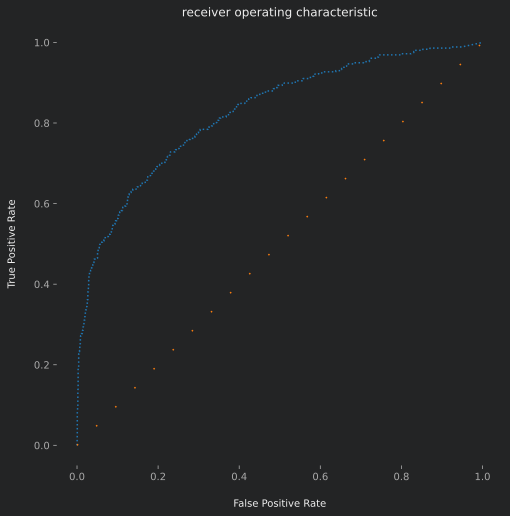

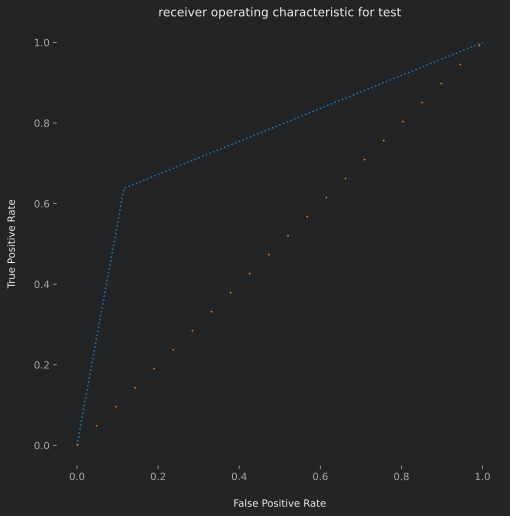

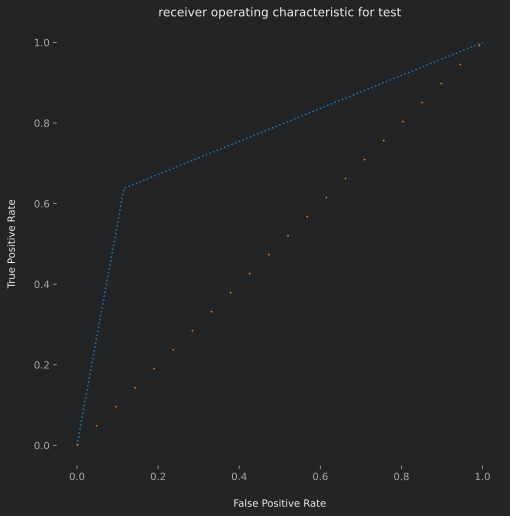

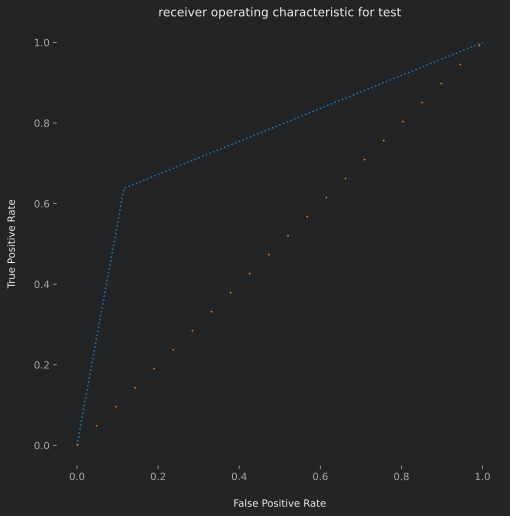

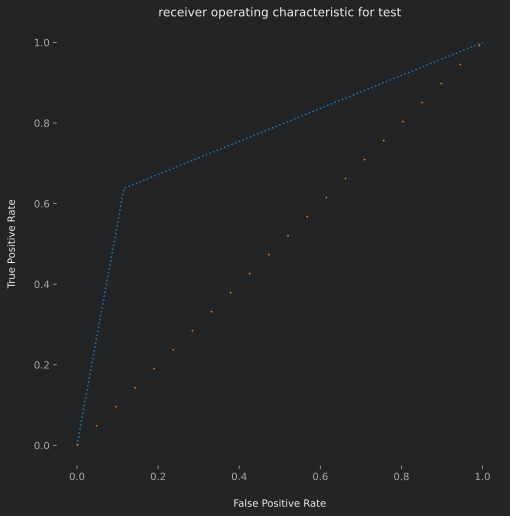

In [70]:
with mpl.rc_context(custom_params):
    plt.figure(
        figsize=(8, 8),
    )
    plt.plot(
        fpr_test,
        tpr_test,
        linestyle='dotted'
    )

    plt.plot(
        [0, 1], [0, 1],
        linestyle=(0, (1, 17)),
    )

    plt.title('receiver operating characteristic for test')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [38]:
predicted_test = model.predict(features_test)

In [39]:
print('f1: {: .4f} \t threshold ={: .4f}'.format(
        f1_score(target_test, probab_one_threshold),
        threshold_nice
    )
 )

F1:  0.6164 	 threshold = 0.3250


In [40]:
print('f1: {: .4f} \t threshold = 0.5'.format(
        f1_score(target_test, predicted_test)
    )
 )

F1:  0.5759 	 threshold = 0.5


### Кратко опишите выводы.

## Улучшите качество модели, учитывая дисбаланс классов.

Добавим стратификацию по `exited`, чтобы выборки содержали категории целевого параметра в равных пропорциях.

In [41]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_ordinal,
    target,
    test_size=0.2,
    random_state=random_seed,
    stratify=target
)

features_train, features_test, target_train, target_test = train_test_split(
    features_train,
    target_train,
    test_size=0.25,
    random_state=random_seed,
    stratify=target_train
)

Со стратификацией по `exited`

In [42]:
print(
    'train amount:\t{:.2%}'.format(len(target_train) / len(target)),
    'valid amount:\t{:.2%}'.format(len(target_valid) / len(target)),
    'test amount:\t{:.2%}'.format(len(target_test) / len(target)),
    '\n',
    'train\'s exited:\t{:.2%}'.format(sum(target_train) / len(target_train)),
    'valid\'s exited:\t{:.2%}'.format(sum(target_valid) / len(target_valid)),
    'test\'s exited:\t{:.2%}'.format(sum(target_test) / len(target_test)),
    sep='\n'
)

train amount:	59.99%
valid amount:	20.01%
test amount:	20.00%


train's exited:	20.39%
valid's exited:	20.40%
test's exited:	20.41%


### Обучите разные модели и найдите лучшую.

#### RandomForestClassifier

In [43]:
rnd_search = RandomizedSearchCV(
    estimator=forest_classifier,
    param_distributions=param,
    n_iter =10,
    # cv=9,
    scoring='f1',
    random_state=random_seed,
)
rnd_search.fit(features_train, target_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=108108108),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [6, 9, 12, 15, None],
                                        'max_features': [1, 3, 5, 7],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'n_estimators': [70, 100, 150]},
                   random_state=108108108, scoring='f1')

In [44]:
print(
    rnd_search.best_params_,
    '\nf1 = {:.4f}'.format(rnd_search.best_score_)
)

{'n_estimators': 150, 'min_samples_leaf': 3, 'max_features': 5, 'max_depth': 15, 'criterion': 'log_loss', 'bootstrap': True} 
f1 = 0.5630


Добавим `class_weight='balanced'` и обучим `RandomForestClassifier`  
> The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

In [45]:
rnd_forest_model = RandomForestClassifier(
    random_state=random_seed,
    class_weight='balanced',
    **rnd_search.best_params_
)

rnd_forest_model.fit(features_train, target_train)
predicted_valid = rnd_forest_model.predict(features_valid)

In [46]:
print('f1: {: .4f}'.format(
        f1_score(target_valid, predicted_valid)
    )
 )

F1:  0.5791


In [47]:
probabilities_valid = model.predict_proba(features_valid)

In [48]:
f1_max = 0
threshold_nice = 0

for threshold in np.arange(0.3, 0.7, 0.005):
    predicted_valid_treshhold = (probabilities_valid[:, 1] >= threshold).astype('int')
    f1_score_treshhold = f1_score(target_valid, predicted_valid_treshhold)
    if f1_score_treshhold > f1_max + 0.0001:
        f1_max = f1_score_treshhold
        threshold_nice = threshold

In [49]:
print('threshold ={: .3f}\tf1:{: .5f}'.format(
        threshold_nice,
        f1_max
    )
)

threshold = 0.395	F1: 0.80939


In [50]:
features_plus_train = pd.concat(
    [features_train, features_valid],
    ignore_index=True
)

target_plus_train = pd.concat(
    [target_train, target_valid],
    ignore_index=True
)

In [51]:
rnd_forest_model.fit(features_plus_train, target_plus_train)

probabilities_test = model.predict_proba(features_test)
predicted_test_treshhold = (probabilities_test[:, 1] >= threshold_nice).astype('int')

In [52]:
print('f1: {: .4f}'.format(
        f1_score(target_test, predicted_test_treshhold)
    )
 )

F1:  0.8006


#### DecisionTreeClassifier

In [57]:
tree_classifier = DecisionTreeClassifier(
    random_state=random_seed,
    class_weight='balanced'
)

In [58]:
tree_param = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [6, 9, 12, 15, 17],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4 , 5],
    'max_features': [1, 3, 5, 7, 9, None],
} 

In [62]:
tree_rnd_search = RandomizedSearchCV(
    estimator=tree_classifier,
    param_distributions=tree_param,
    n_iter =10,
    cv=9,
    scoring='f1',
    random_state=random_seed,
)
tree_rnd_search.fit(features_train, target_train)

RandomizedSearchCV(cv=9,
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=108108108),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [6, 9, 12, 15, 17],
                                        'max_features': [1, 3, 5, 7, 9, None],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 3, 4, 5]},
                   random_state=108108108, scoring='f1')

In [63]:
print(
    tree_rnd_search.best_params_,
    '\nf1 = {:.4f}'.format(tree_rnd_search.best_score_)
)

{'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 9, 'max_depth': 6, 'criterion': 'log_loss'} 
f1 = 0.5523


In [65]:
dcsn_tree_model = DecisionTreeClassifier(
    random_state=random_seed,
    class_weight='balanced',
    **tree_rnd_search.best_params_
)

dcsn_tree_model.fit(features_train, target_train)
predicted_valid = dcsn_tree_model.predict(features_valid)

In [67]:
print('f1: {: .4f}'.format(
        f1_score(target_valid, predicted_valid)
    )
 )

f1:  0.5594


In [84]:
def plot_acu_roc(fpr, tpr, title, custom_params=custom_params):
    with mpl.rc_context(custom_params):
        plt.figure(
            figsize=(8, 8),
        )
        plt.plot(
            fpr,
            tpr,
            linestyle='dotted'
        )

        plt.plot(
            [0, 1], [0, 1],
            linestyle=(0, (1, 17)),
        )

        plt.title(title)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

In [85]:
predicted_valid = dcsn_tree_model.predict(features_valid)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(target_valid, predicted_valid)

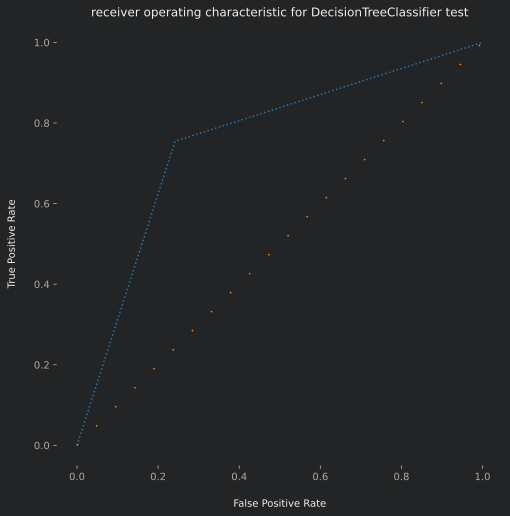

In [87]:
plot_acu_roc(
    fpr_valid,
    tpr_valid,
    'receiver operating characteristic for DecisionTreeClassifier test',
)

In [88]:
probabilities_valid = dcsn_tree_model.predict_proba(features_valid)

In [91]:
 def threshold_finder(probabilities_valid):
    f1_max = 0
    threshold_nice = 0

    for threshold in np.arange(0.2, 0.8, 0.005):
        predicted_valid_treshhold = (probabilities_valid[:, 1] >= threshold).astype('int')
        f1_score_treshhold = f1_score(target_valid, predicted_valid_treshhold)
        if f1_score_treshhold > f1_max + 0.0001:
            f1_max = f1_score_treshhold
            threshold_nice = threshold
    return [f1_max, threshold_nice]

In [92]:
f1_max, threshold_nice = threshold_finder(probabilities_valid)

In [93]:
print('threshold ={: .3f}\tf1:{: .5f}'.format(
        threshold_nice,
        f1_max
    )
)

threshold = 0.585	F1: 0.59126


In [95]:
dcsn_tree_model.fit(features_plus_train, target_plus_train)

probabilities_test = dcsn_tree_model.predict_proba(features_test)
predicted_test_treshhold = (probabilities_test[:, 1] >= threshold_nice).astype('int')

In [97]:
print('f1: {: .4f}'.format(
        f1_score(target_test, predicted_test_treshhold)
    )
 )

f1:  0.5906


#### LogisticRegression

### Кратко опишите выводы.

## Проведите финальное тестирование.

Признаки
`RowNumber` — индекс строки в данных  
`CustomerId` — уникальный идентификатор клиента  
`Surname` — фамилия  
`CreditScore` — кредитный рейтинг  
`Geography` — страна проживания  
`Gender` — пол  
`Age` — возраст  
`Tenure` — сколько лет человек является клиентом банка  
`Balance` — баланс на счёте  
`NumOfProducts` — количество продуктов банка, используемых клиентом  
`HasCrCard` — наличие кредитной карты  
`IsActiveMember` — активность клиента  
`EstimatedSalary` — предполагаемая зарплата  
`Целевой` признак  
`Exited` — факт ухода клиента  

## Как будут проверять мой проект?


На что обращают внимание ревьюер, проверяя проект:
 - Как вы готовите данные к обучению? Все ли типы признаков обрабатываете?
 - Хорошо ли поясняете этапы предобработки?
 - Как исследуете баланс классов?
 - Изучаете ли модель без учёта дисбаланса классов?
 - Какие выводы об исследовании задачи делаете?
 - Корректно ли разбиваете данные на выборки?
 - Как работаете с несбалансированными классами?
 - Правильно ли проводите обучение, валидацию и финальное тестирование модели?
 - Насколько высокое значение f1-меры получаете?
 - Изучаете ли значения метрики AUC-ROC?
 - Следите за структурой проекта и поддерживаете аккуратность кода?